In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import folium 
import plotly.express as px 
import sklearn
import osmnx as ox 
import networkx as nx 
from ortools.constraint_solver import pywrapcp 
from ortools.constraint_solver import routing_enums_pb2


In [2]:
city = "London"
dtf=pd.read_csv('data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23


In [3]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [4]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row: 
    folium.CircleMarker(
        location=[row["y"], row["x"]], 
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map 

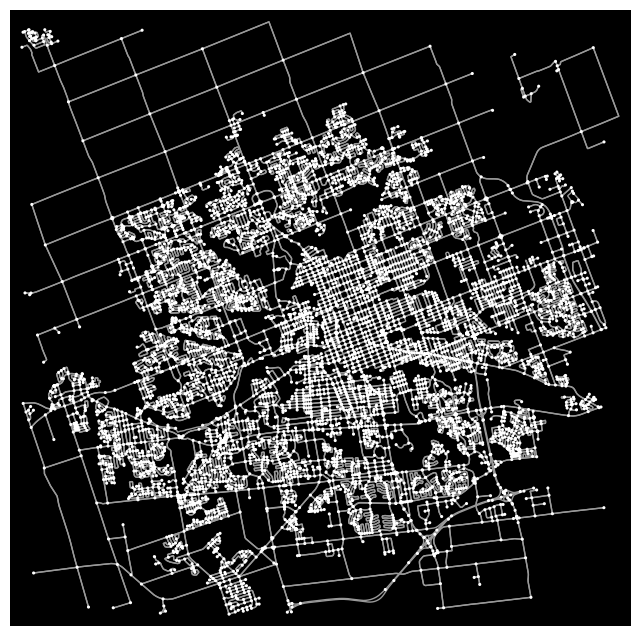

In [5]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [6]:
import osmnx as ox 
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()


C:\Users\neetammdr\AppData\Local\Temp\ipykernel_9088\2981975553.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\neetammdr\AppData\Local\Temp\ipykernel_9088\2981975553.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
C:\Users\neetammdr\AppData\Local\Temp\ipykernel_9088\2981975553.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated a

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [7]:
import numpy as np
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.000000,562.879638,353.062231,594.714108,498.756381,403.383493,126.568463,393.757943,554.838587,101.815809,514.114180,435.292483,233.321103,199.001035,567.102012,226.283022,522.995916,477.120519,1034.605763,1047.001691
324811692,590.173713,0.000000,210.854993,1099.747589,950.709561,713.170050,458.114738,871.444296,736.598155,489.691198,402.678032,890.448605,670.110890,403.241314,680.717037,777.614566,119.618465,982.154000,1311.267733,782.657357
11756886360,379.318720,209.817407,0.000000,913.372457,739.854568,579.158026,247.259744,660.589303,550.223024,278.836205,412.547349,704.073473,459.255897,192.386321,582.677452,579.372290,239.878970,795.778868,1201.705180,915.003532
252974916,592.990749,1096.634969,915.098982,0.000000,428.971598,858.422785,704.908320,323.973160,481.424322,665.854840,725.882878,356.010000,500.979747,764.566837,1083.595879,433.006525,1026.221548,174.879249,1306.624095,979.735407
302754873,498.679906,951.729386,741.911979,429.981326,0.000000,480.695121,573.158005,107.369356,892.042714,513.652320,865.035919,764.768290,348.777226,568.967158,705.868214,395.057894,981.570889,312.387737,928.896430,1390.353800


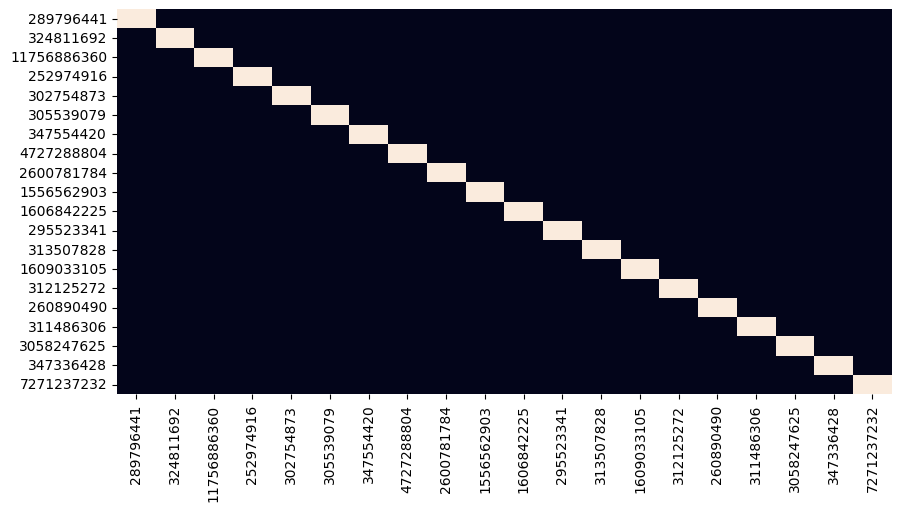

In [ ]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x: 
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else 
          (0 if x!=0 else 1)) )
    
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [ ]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,563,353,595,499,403,127,394,555,102,514,435,233,199,567,226,523,477,1035,1047
324811692,590,0,211,1100,951,713,458,871,737,490,403,890,670,403,681,777,120,982,1311,783
11756886360,379,210,0,913,740,579,247,661,550,279,412,704,459,192,582,579,240,796,1202,915
252974916,593,1097,915,0,429,858,705,324,481,666,726,356,501,765,1084,433,1026,175,1306,980
302754873,499,952,742,430,0,481,573,107,892,514,865,765,349,569,706,395,981,312,929,1390
305539079,403,645,583,861,485,0,436,539,894,376,867,767,411,410,309,558,747,744,688,1362
347554420,150,456,246,716,572,435,0,467,520,92,479,518,265,93,491,349,425,598,1067,1012
4727288804,391,869,659,323,107,537,466,0,785,406,758,657,241,505,762,288,874,205,985,1283
2600781784,555,732,550,478,887,890,521,782,0,603,361,185,720,578,1002,563,662,633,1521,633
1556562903,170,488,278,668,512,376,92,407,603,0,562,538,206,124,492,336,501,551,1007,1095


In [8]:
drivers = 1 
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [9]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [10]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [12]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))
    
    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)
        
print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Total distance:13.38km
Nodes visited: 20


In [15]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 7271237232, 347336428, 3058247625, 311486306, 260890490, 312125272, 1609033105, 313507828, 295523341, 1606842225, 1556562903, 2600781784, 4727288804, 347554420, 305539079, 302754873, 252974916, 11756886360, 324811692]


In [19]:
import folium


def get_path_between_nodes(lst_route):
    lst_paths=[]
    for i in range (len(lst_route)):
        try :
            a , b = lst_nodes[i], lst_nodes[i+1]
        except:
            break
        try:
            path=nx.shortest_path(G, source=a, target=b, method ='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except:
            continue
    return lst_paths

lst_paths= get_path_between_nodes(lst_route)

for path in lst_paths:
    ox.plot_route_folium(G, route=path, route_map=map, color="blue", weight=1)
    
map

AttributeError: module 'osmnx' has no attribute 'plot_route_folium'

In [17]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], [] 
        
        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])
            
        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)), 
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))
        
    df=df.reset_index().rename(columns={"index":"id"})
    return df
            

In [ ]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [ ]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig



C:\Users\neetammdr\AppData\Local\Temp\ipykernel_26432\1264307401.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\neetammdr\AppData\Local\Temp\ipykernel_26432\1264307401.py:8: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\neetammdr\AppData\Local\Temp\ipykernel_26432\1264307401.py:11: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\neetammdr\AppData\Local\Temp\ipykernel_26432\1264307401.py:14: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

C:\Users\neetammdr\AppData\Local\Temp\ipykernel_26432\1264307401.py:17: DeprecationWarning:

*line_mapbox* is deprecated! Use *line_map* instead. 

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'id=0<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': {'bdata': 'Q7Fw7Z9+RUA=', 'dtype': 'f8'},
              'legendgroup': '',
              'lon': {'bdata': 'JrvjXqpQVMA=', 'dtype': 'f8'},
              'marker': {'size': 12},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'y=%{lat}<br>x=%{lon}<extra></extra>',
              'lat': {'bdata': ('H4XrUbh+RUDXo3A9CndFQHsUrkfhek' ... 'yPgkVAexSuR+G6SUCuR+F6FI5CQA=='),
                      'dtype': 'f8'},
              'legendgroup': '',
              'lon': {'bdata': ('cT0K16NQVMCuR+F6FE5UwB+F61G4Tl' ... 'rXU1TAw/UoXI/Cxb9mZmZmZgZVwA=='),
                      'dtype': 'f8'},
              'marker': {'color': 'black', 'size': 10},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': {'bdata': 'Q7Fw7Z9+RUA=', 'dtype': 'f8'},
              'legendgroup': '',
              'lon': {'bdata': 'JrvjXqpQVMA=', 'dtype': 'f8'},
              'marker': {'color': 'red', 'size': 15},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': {'bdata': 'ksoUcxB1RUA=', 'dtype': 'f8'},
              'legendgroup': '',
              'lon': {'bdata': 'htFi3wRXVMA=', 'dtype': 'f8'},
              'marker': {'color': 'green', 'size': 15},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'},
             {'hovertemplate': 'start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
              'lat': {'bdata': ('Q7Fw7Z9+RUC7SWe7nX5FQM0NPK2Rfk' ... 'zEdEVAuhXCaix1RUCSyhRzEHVFQA=='),
                      'dtype': 'f8'},
              'legendgroup': '',
              'line': {'color': '#636efa'},
              'lon': {'bdata': ('JrvjXqpQVMDFlKNbilBUwEV69gFtUF' ... 'iRVVTAGgl+Ze9VVMCG0WLfBFdUwA=='),
                      'dtype': 'f8'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox'}],
    'frames': [{'data': [{'hovertemplate': 'id=0<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
                          'lat': {'bdata': 'Q7Fw7Z9+RUA=', 'dtype': 'f8'},
                          'legendgroup': '',
                          'lon': {'bdata': 'JrvjXqpQVMA=', 'dtype': 'f8'},
                          'marker': {'color': '#636efa'},
                          'mode': 'markers',
                          'name': '',
                          'showlegend': False,
                          'subplot': 'mapbox',
                          'type': 'scattermapbox'}],
                'name': '0'},
               {'data': [{'hovertemplate': 'id=1<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
                          'lat': {'bdata': 'u0lnu51+RUA=', 'dtype': 'f8'},
                          'legendgroup': '',
                          'lon': {'bdata': 'xZSjW4pQVMA=', 'dtype': 'f8'},
                          'marker': {'color': '#636efa'},
                          'mode': 'markers',
                          'name': '',
                          'showlegend': False,
                          'subplot': 'mapbox',
                          'type': 'scattermapbox'}],
                'name': '1'},
               {'data': [{'hovertemplate': 'id=2<br>start_y=%{lat}<br>start_x=%{lon}<extra></extra>',
                          'lat': {'bdata': 'zQ08rZ